# EuroSciPy 2019 - 3D image processing with scikit-image

* Support material for the tutorial _3D image processing with scikit-image_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric images in Python, mainly using scikit-image. Here we will learn how to:
 * pre-process data using filtering, binarization and segmentation techniques.
 * inspect, count and measure attributes of objects and regions of interest in the data.
 * visualize large 3D data.

For more info:
  * [[EuroSciPy (all editions)]](https://www.euroscipy.org/)
  * [[EuroSciPy 2019]](https://www.euroscipy.org/2019/)
  * [[scikit-image]](https://scikit-image.org/)
  * [[scikit-image tutorials]](https://github.com/scikit-image/skimage-tutorials)

Please refer to the scikit-image tutorials when using this material.

## What is scikit-image?

scikit-image is a collection of image processing algorithms which aims to integrate well with for the SciPy ecosystem.

It is well documented, and provides well-tested code to quickly build sophisticated image processing pipelines.


## Checking the system

First, we'll check if your system have the necessary packages.

In [1]:
%run check_setup.py

[✓] numpy            1.21.3
[✓] scipy            1.7.1
[✓] matplotlib       3.4.3
[✓] scikit-image     0.18.3
[✓] jupyter-notebook 6.4.5
[✓] itk              5.2.1
[✓] itkwidgets       0.32.1
[✓] joblib           1.1.0


## Importing the base Scientific Python ecossystem

Let's start importing the basics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import ndimage

%matplotlib inline

Then, let's set a nice, `monospace` font for matplotlib's figures.

In [3]:
plt.rcParams['font.family'] = 'monospace'

## Introduction to three-dimensional image processing

In scikit-image, images are represented as `numpy` arrays.

A grayscale image is a 2D matrix of pixel intensities of shape `(row, column)`. They are also called single-channel images. Multi-channel data has an extra dimension, `channel`, in the final position. `channel` contains color information. 

We can construct a 3D volume as a series of 2D `planes`, giving 3D images the shape `(plane, row, column)`.

Summarizing:

|Image type|Coordinates|
|:---|:---|
|2D grayscale|(row, column)|
|2D multichannel|(row, column, channel)|
|3D grayscale|(plane, row, column)|
|3D multichannel|(plane, row, column, channel)|

Some 3D images are constructed with equal resolution in each dimension. An example would be a computer generated rendering of a sphere with dimensions `(30, 30, 30)`: 30 planes, 30 rows and 30 columns.

However, most experimental data captures one dimension at a lower resolution than the other two. For example, photographing thin slices to approximate a 3D structure as a stack of 2D images. We will work with one example of such data in this tutorial.


## [skimage.io](https://scikit-image.org/docs/stable/api/skimage.io.html) - utilities to read and write images in various formats<a id='io'></a>

This module helps us on reading images and saving the results. There are multiple plugins available, which support multiple formats. The most commonly used functions include:

* `io.imread`: read an image to a numpy array.
* `io.imsave`: write an image to disk.
* `io.imread_collection`: read multiple images which match a common pattern.

Data can be loaded with `io.imread`, as in the following example.

In [4]:
from skimage import io  # skimage's I/O submodule.

In [5]:
cells = io.imread('../../images/cells.tif')

First let's check its shape, data type and range.

In [6]:
print('* "cells" shape: {}'.format(cells.shape))
print('* "cells" type: {}'.format(cells.dtype))
print('* "cells" range: {}, {}'.format(cells.min(), cells.max()))

* "cells" shape: (60, 256, 256)
* "cells" type: float64
* "cells" range: 0.0, 1.0


We see that `cells` has 60 planes, each with 256 rows and 256 columns. Let's try visualizing the image with `skimage.io.imshow`.

Invalid shape (60, 256, 256) for image data


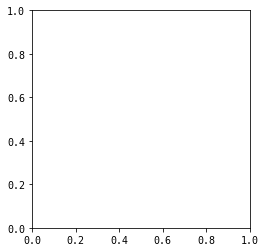

In [7]:
try:
    io.imshow(cells, cmap='gray')
except TypeError as error:
    print(str(error))

`skimage.io.imshow` can only display grayscale and RGB(A) 2D images. We can use `skimage.io.imshow` to visualize 2D planes. Let's use some helping functions for checking 3D data, then.

All supplementary functions we will use during this tutorial are stored within `supplementary_code.py`. First, we import this file:

In [8]:
import supplementary_code as sc

By fixing one axis, we can observe three different views of the image. Let's use the helper function `show_plane` to do that.

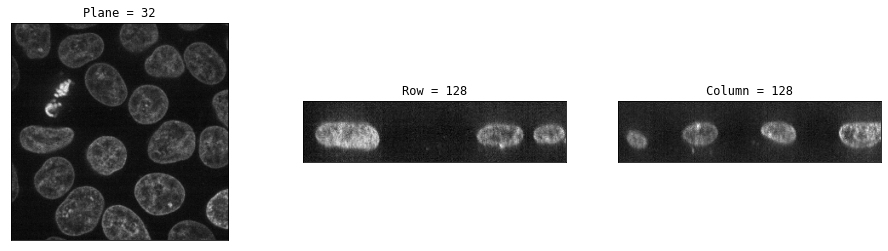

In [9]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, cells[32], title='Plane = 32')
sc.show_plane(win_center, cells[:, 128, :], title='Row = 128')
sc.show_plane(win_right, cells[:, :, 128], title='Column = 128')

Three-dimensional images can be viewed as a series of two-dimensional ones. The `slice_explorer` helper presents a slider to check the 2D planes.

In [10]:
sc.slice_explorer(cells)

interactive(children=(IntSlider(value=30, description='plane', max=59), Output()), _dom_classes=('widget-inter…

<function supplementary_code.slice_explorer.<locals>.display_slice(plane=30.0)>

The `display` helper function, on the other hand, displays 30 planes of the provided image. By default, every other plane is displayed.

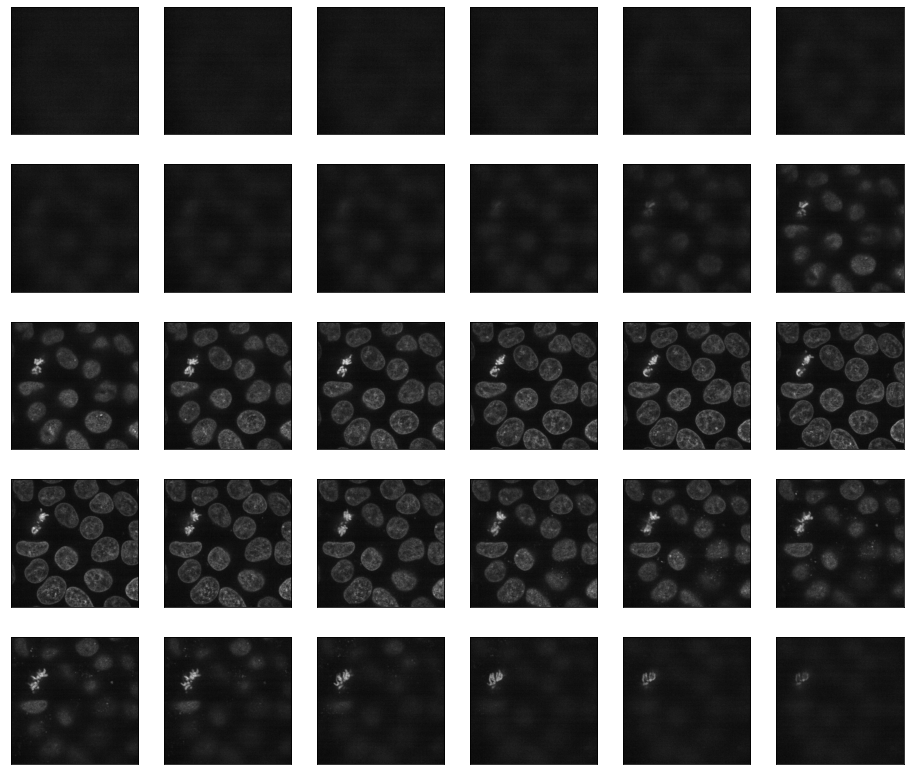

In [11]:
sc.display(cells)

__Exercise: <font color='red'>(3 min, shall we? 🙄)</font>__ there is another dataset within the folder `image`, called `bead_pack.tif`.

Now, using what we saw so far, there's some tasks for you:
  * Read this data and check its shape, data type, minimum and maximum values.
  * Check the slices using the function `slice_explorer`.
  * Display each six slices using the function `display` (you will use the variable `step` for that).

* "beadpack" shape: (200, 200, 200)
* "beadpack" type: uint8
* "beadpack" range: 29, 239


interactive(children=(IntSlider(value=100, description='plane', max=199), Output()), _dom_classes=('widget-int…

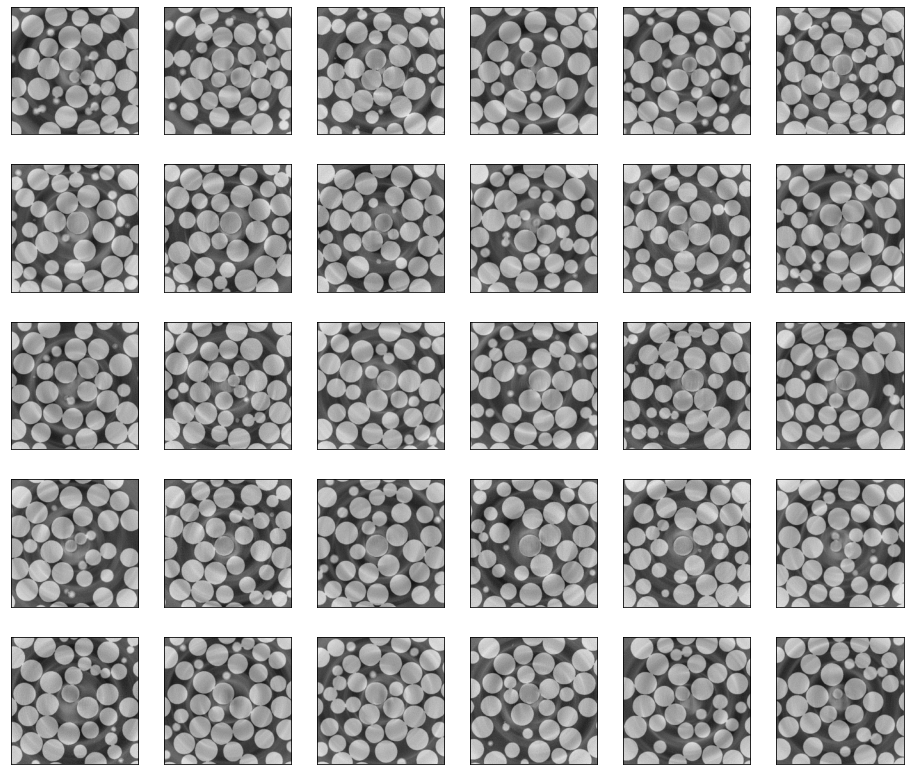

In [12]:
# Your solution goes here!
beadpack = io.imread('data/bead_pack.tif')

print('* "beadpack" shape: {}'.format(beadpack.shape))
print('* "beadpack" type: {}'.format(beadpack.dtype))
print('* "beadpack" range: {}, {}'.format(beadpack.min(),
                                          beadpack.max()))

sc.slice_explorer(beadpack)
sc.display(beadpack, step=6)

## [skimage.exposure](https://scikit-image.org/docs/stable/api/skimage.exposure.html) - evaluating or changing the exposure of an image<a id='exposure'></a>

This module contains a number of functions for adjusting image contrast. We will use some of them:

* `exposure.adjust_gamma`: gamma correction.
* `exposure.equalize_hist`: histogram equalization.

[Gamma correction](https://en.wikipedia.org/wiki/Gamma_correction), also known as Power Law Transform, brightens or darkens an image. The function $O = I^\gamma$ is applied to each pixel in the image. A `gamma < 1` will brighten an image, while a `gamma > 1` will darken an image.

One of the most common tools to evaluate exposure is the *histogram*, which plots the number of points which have a certain value against the values in order from lowest (dark) to highest (light).

In [13]:
from skimage import exposure  # skimage's exposure module.

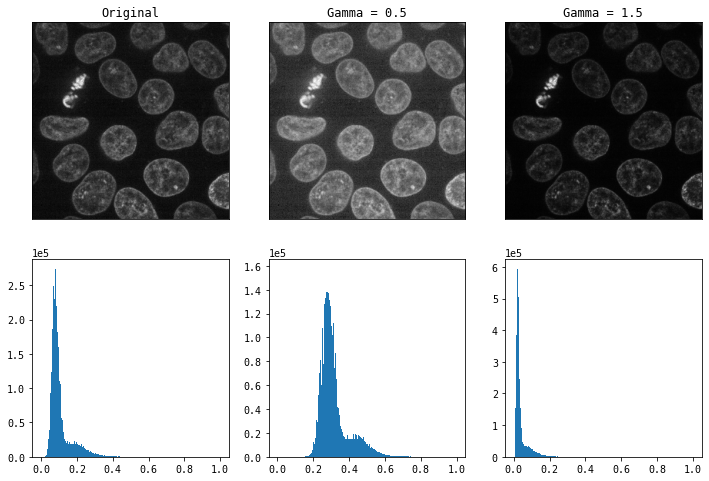

In [14]:
gamma_val_low = 0.5
cells_gamma_low = exposure.adjust_gamma(cells, gamma=gamma_val_low)

gamma_val_high = 1.5
cells_gamma_high = exposure.adjust_gamma(cells, gamma=gamma_val_high)

_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Original and its histogram.
sc.show_plane(win_top_left, cells[32], title='Original')
sc.plot_hist(win_bottom_left, cells)

# Gamma = 0.5 and its histogram.
sc.show_plane(win_top_center, cells_gamma_low[32], title='Gamma = {}'.format(gamma_val_low))
sc.plot_hist(win_bottom_center, cells_gamma_low)

# Gamma = 1.5 and its histogram.
sc.show_plane(win_top_right, cells_gamma_high[32], title='Gamma = {}'.format(gamma_val_high))
sc.plot_hist(win_bottom_right, cells_gamma_high)

[Histogram equalization](https://en.wikipedia.org/wiki/Histogram_equalization) improves contrast in an image by redistributing pixel intensities. The most common pixel intensities are spread out, allowing areas of lower local contrast to gain a higher contrast. This may enhance background noise.

In [ ]:
cells_equalized = exposure.equalize_hist(cells)

sc.slice_explorer(cells_equalized)

_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

sc.plot_hist(win_top_left, cells, title='Original')
sc.plot_hist(win_top_right, cells_equalized, title='Histogram equalization')

cdf, bins = exposure.cumulative_distribution(cells.ravel())
win_bottom_left.plot(bins, cdf, 'r')
win_bottom_left.set_title('Original CDF')

cdf, bins = exposure.cumulative_distribution(cells_equalized.ravel())
win_bottom_right.plot(bins, cdf, 'r')
win_bottom_right.set_title('Histogram equalization CDF');

Most experimental images are affected by salt and pepper noise. A few bright artifacts can decrease the relative intensity of the pixels of interest. A simple way to improve contrast is to clip the pixel values on the lowest and highest extremes. Clipping the darkest and brightest 0.5% of pixels will increase the overall contrast of the image.

In [ ]:
vmin, vmax = np.percentile(cells, q=(0.5, 99.5))

cells_clipped = exposure.rescale_intensity(
    cells,
    in_range=(vmin, vmax), 
    out_range=np.float32
)

sc.slice_explorer(cells_clipped);

We'll call our dataset `cells_rescaled` from now on. In this cell, you can choose any of the previous results to continue working with.

In the next steps, we'll use the `cells_clipped` version.

In [ ]:
cells_rescaled = cells_clipped

__Exercise: <font color='red'>(7-ish min? 🙄)</font>__ now, using our variable `beadpack`, let's repeat the process, ok?

Now, using what we saw so far, there's some tasks for you:
  * Obtain a nice `gamma_val` to adjust the gamma of `beadpack`.
  * Equalize `beadpack`'s histogram using `equalize_hist` and CLAHE (given by `equalize_adapthist`).
  * Increase `beadpack`'s contrast by clipping the darkest/brightest pixels there. Try different percentages.
  * Choose the data you think is best, and call it `beadpack_rescaled`.

In [ ]:
# Part #1 of your solution goes here!
gamma_val = 0.7
beadpack_gamma = exposure.adjust_gamma(beadpack, gamma=gamma_val)

_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

# Original and its histogram.
sc.show_plane(win_top_left, beadpack[32], title='Original')
sc.plot_hist(win_bottom_left, beadpack)

# Gamma-adjusted and its histogram.
sc.show_plane(win_top_right, beadpack_gamma[32], title='Gamma = {}'.format(gamma_val))
sc.plot_hist(win_bottom_right, beadpack_gamma)

In [ ]:
# Part #2 of your solution goes here!

# let's convert beadpack to float; it'll help us on the future.
from skimage import util
beadpack = util.img_as_float(beadpack)

# First, let's create a version using histogram equalization. 
beadpack_equalized = exposure.equalize_hist(beadpack)
sc.slice_explorer(beadpack_equalized)

# Now, a version using CLAHE. 
beadpack_clahe = np.empty_like(beadpack)

for plane, image in enumerate(beadpack):
    beadpack_clahe[plane] = exposure.equalize_adapthist(image)
sc.slice_explorer(beadpack_clahe)

# Let's check the results.
_, ((win_top_left, win_top_center, win_top_right),
    (win_bottom_left, win_bottom_center, win_bottom_right)) = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

sc.plot_hist(win_top_left, beadpack, title='Original')
sc.plot_hist(win_top_center, beadpack_equalized, title='Histogram equalization')
sc.plot_hist(win_top_right, beadpack_clahe, title='CLAHE')

cdf, bins = exposure.cumulative_distribution(beadpack.ravel())
win_bottom_left.plot(bins, cdf, 'r')
win_bottom_left.set_title('Original CDF')

cdf, bins = exposure.cumulative_distribution(beadpack_equalized.ravel())
win_bottom_center.plot(bins, cdf, 'r')
win_bottom_center.set_title('Histogram equalization CDF');

cdf, bins = exposure.cumulative_distribution(beadpack_clahe.ravel())
win_bottom_right.plot(bins, cdf, 'r')
win_bottom_right.set_title('CLAHE CDF');

In [ ]:
# Part #3 of your solution goes here!
vmin, vmax = np.percentile(data, q=)

beadpack_clipped = exposure.rescale_intensity(
    beadpack,
    in_range=(vmin, vmax), 
    out_range=np.float32
)

sc.slice_explorer(beadpack_clipped);

In [ ]:
# Now, choose your destiny!
beadpack_rescaled = 

## Edge detection

[Edge detection](https://en.wikipedia.org/wiki/Edge_detection) highlights regions in the image where a sharp change in contrast occurs. The intensity of an edge corresponds to the steepness of the transition from one intensity to another. A gradual shift from bright to dark intensity results in a dim edge. An abrupt shift results in a bright edge.

The [Sobel operator](https://en.wikipedia.org/wiki/Sobel_operator) is an edge detection algorithm which approximates the gradient of the image intensity, and is fast to compute.


## [skimage.filters](https://scikit-image.org/docs/stable/api/skimage.filters.html) - apply filters to an image<a id='filters'></a>

Filtering applies whole-image modifications such as sharpening or blurring. In addition to edge detection, `skimage.filters` provides functions for filtering and thresholding images.

Notable functions include (links to relevant gallery examples):

* [Thresholding](https://scikit-image.org/docs/stable/auto_examples/applications/plot_thresholding.html):
  * `filters.threshold_*` (multiple different functions with this prefix)
  * `filters.try_all_threshold` to compare various methods
* [Edge finding/enhancement](https://scikit-image.org/docs/stable/auto_examples/edges/plot_edge_filter.html):
  * `filters.sobel` - not adapted for 3D images. It can be applied planewise to approximate a 3D result.
  * `filters.prewitt`
  * `filters.scharr`
  * `filters.roberts`
  * `filters.laplace`
  * `filters.hessian`
* [Ridge filters](https://scikit-image.org/docs/stable/auto_examples/edges/plot_ridge_filter.html):
  * `filters.meijering`
  * `filters.sato`
  * `filters.frangi`
* Inverse filtering (see also [skimage.restoration](#restoration)):
  * `filters.weiner`
  * `filters.inverse`
* [Directional](https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_gabor.html): `filters.gabor`
* Blurring/denoising
  * `filters.gaussian`
  * `filters.median`
* [Sharpening](https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html): `filters.unsharp_mask`
* Define your own filter: `LPIFilter2D`
  
The sub-submodule `skimage.filters.rank` contains rank filters. These filters are nonlinear and operate on the local histogram.

In [15]:
from skimage import filters  # skimage's filtering module

In [16]:
cells_sobel = np.empty_like(cells_rescaled)

for plane, image in enumerate(cells_rescaled):
    cells_sobel[plane] = filters.sobel(image)
    
sc.slice_explorer(cells_sobel)

NameError: name 'cells_rescaled' is not defined

In [ ]:
_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 4))

sc.show_plane(win_top_left, cells_sobel[:, 128, :], title='3D sobel, row = 128')

cells_sobel_row = filters.sobel(cells_rescaled[:, 128, :])
sc.show_plane(win_top_right, cells_sobel_row, title='2D sobel, row=128')

sc.show_plane(win_bottom_left, cells_sobel[:, :, 128], title='3D sobel, column = 128')

cells_sobel_col = filters.sobel(cells_rescaled[:, :, 128])
sc.show_plane(win_bottom_right, cells_sobel_col, title='2D sobel, column=128')

## [skimage.transform](https://scikit-image.org/docs/stable/api/skimage.transform.html) - transforms & warping<a id='transform'></a>

This submodule has multiple features which fall under the umbrella of transformations.

Forward (`radon`) and inverse (`iradon`) radon transforms, as well as some variants (`iradon_sart`) and the finite versions of these transforms (`frt2` and `ifrt2`).  These are used for [reconstructing medical computed tomography (CT) images](https://scikit-image.org/docs/stable/auto_examples/transform/plot_radon_transform.html).

Hough transforms for identifying lines, circles, and ellipses.

Changing image size, shape, or resolution with `resize`, `rescale`, or `downscale_local_mean`.

`warp`, and `warp_coordinates` which take an image or set of coordinates and translate them through one of the defined `*Transforms` in this submodule.  `estimate_transform` may be assist in estimating the parameters.

[Numerous gallery examples are available](https://scikit-image.org/docs/stable/auto_examples/index.html#geometrical-transformations-and-registration) illustrating these functions.  [The panorama tutorial also includes warping](./solutions/adv3_panorama-stitching-solution.ipynb) via `SimilarityTransform` with parameter estimation via `measure.ransac`.

In [ ]:
from skimage import transform  # skimage's transform submodule.

We created the illustration below to illustrate the downsampling operation. The red dots show the pixels within each image.

In [ ]:
# To make sure we all see the same thing, let's set a seed
np.random.seed(0)

image = np.random.random((8, 8))
image_rescaled = transform.downscale_local_mean(image, (4, 4))

_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

win_left.imshow(image, cmap='gray')
win_left.set_xticks([])
win_left.set_yticks([])
centers = np.indices(image.shape).reshape(2, -1).T
win_left.plot(centers[:, 0], centers[:, 1], '.r')
win_left.set_title('Original: {}'.format(image.shape))

win_right.imshow(image_rescaled, cmap='gray')
win_right.set_xticks([])
win_right.set_yticks([])
centers = np.indices(image_rescaled.shape).reshape(2, -1).T
win_right.plot(centers[:, 0], centers[:, 1], '.r');
win_right.set_title('Downsampled: {}'.format(image_rescaled.shape))

The distance between pixels in each dimension, called `spacing`, is encoded in a tuple and is accepted as a parameter by some `skimage` functions and can be used to adjust contributions to filters.

The distance between pixels was reported by the microscope used to image the cells. This `spacing` information will be used to adjust contributions to filters and helps decide when to apply operations planewise. We've chosen to downsample each slice by a factor of 4 in the `row` and `column` dimensions to make the data smaller, thus reducing computational time. We also normalize it to `1.0` in the `row` and `column` dimensions.

In [ ]:
# The microscope reports the following spacing:
original_spacing = np.array([0.2900000, 0.0650000, 0.0650000])
print('* Microscope original spacing: {}'.format(original_spacing))

# We downsampled each slice 4x to make the data smaller
rescaled_spacing = original_spacing * [1, 4, 4]
print('* Microscope after rescaling images: {}'.format(rescaled_spacing))

# Normalize the spacing so that pixels are a distance of 1 apart
spacing = rescaled_spacing / rescaled_spacing[2]
print('* Microscope normalized spacing: {}'.format(spacing))

__Exercise: <font color='red'>(3-ish min? 🙄)</font>__ now, using our variable `beadpack_rescaled`, let's check its edges.

Your tasks right now are:
  * Use the Sobel edge filter to obtain the edges of `beadpack_rescaled`.
  * Explore the edges at each depth.
  * Check 2D and 3D Sobel filters when row and column are equal to 100.

In [ ]:
# Your solution goes here!
beadpack_sobel = np.empty_like()

for plane, image in enumerate():
    beadpack_sobel[plane] = filters.sobel(image)

sc.slice_explorer(beadpack_sobel)

_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 14))

sc.show_plane(win_top_left, , title='3D sobel, row=100')

beadpack_sobel_row = filters.sobel()
sc.show_plane(win_top_right, , title='2D sobel, row=100')

sc.show_plane(win_bottom_left, , title='3D sobel, column=100')

beadpack_sobel_col = filters.sobel()
sc.show_plane(win_bottom_right, , title='2D sobel, column=100')

## Filters

[Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) applies a Gaussian function to an image, creating a smoothing effect. `skimage.filters.gaussian` takes as input `sigma` which can be a scalar or a sequence of scalar. This `sigma` determines the standard deviation of the Gaussian along each axis. When the resolution in the `plane` dimension is much worse than the `row` and `column` dimensions, dividing `base_sigma` by the image `spacing` will balance the contribution to the filter along each axis.

In [ ]:
base_sigma = 2.0
sigma = base_sigma / spacing

cells_gaussian = filters.gaussian(cells_rescaled, multichannel=False, sigma=sigma)

sc.slice_explorer(cells_gaussian);

[Median filter](https://en.wikipedia.org/wiki/Median_filter) is a noise removal filter. It is particularly effective against salt and pepper noise. An additional feature of the median filter is its ability to preserve edges. This is helpful in segmentation because the original shape of regions of interest will be preserved.

`skimage.filters.median` does not support three-dimensional images and needs to be applied planewise.

## [skimage.util](https://scikit-image.org/docs/stable/api/skimage.util.html) - utility functions<a id='util'></a>

These are generally useful functions which have no definite other place in the package.

* `util.img_as_*` are convenience functions for datatype conversion.

* `util.invert` is a convenient way to invert any image, accounting for its datatype.

* `util.random_noise` is a comprehensive function to apply any amount of many different types of noise to images.  The seed may be set, resulting in pseudo-random noise for testing.

* `util.view_as_*` allows for overlapping views into the same memory array, which is useful for elegant local computations with minimal memory impact.

* `util.apply_parallel` uses Dask to apply a function across subsections of an image.  This can result in dramatic performance or memory improvements, but depending on the algorithm edge effects or lack of knowledge of the remainder of the image may result in unexpected results.

* `util.pad` and `util.crop` pads or crops the edges of images.  `util.pad` is now a direct wrapper for `numpy.pad`.

In [ ]:
from skimage import util  # skimage's util submodule.

In [ ]:
cells_rescaled_ubyte = util.img_as_ubyte(cells_rescaled)

cells_median = np.empty_like(cells_rescaled_ubyte)

for plane, image in enumerate(cells_rescaled_ubyte):
    cells_median[plane] = filters.median(image)
    
cells_median = util.img_as_float(cells_median)
    
sc.slice_explorer(cells_median);

## [skimage.restoration](https://scikit-image.org/docs/stable/api/skimage.restoration.html) - restoration of an image<a id='restoration'></a>

This submodule includes routines to restore images.  Currently these routines fall into four major categories.  Links lead to topical gallery examples.

* `restoration.denoise_*` - [Reducing noise](https://scikit-image.org/docs/stable/auto_examples/filters/plot_denoise.html).
* [Deconvolution](https://scikit-image.org/docs/stable/auto_examples/filters/plot_deconvolution.html), or reversing a convolutional effect which applies to the entire image. This can be done in an [unsupervised](https://scikit-image.org/docs/stable/auto_examples/filters/plot_restoration.html) way.
  * `restoration.weiner`
  * `restoration.unsupervised_weiner`
  * `restoration.richardson_lucy`
* `restoration.inpaint_biharmonic` - [Inpainting](https://scikit-image.org/docs/stable/auto_examples/filters/plot_inpaint.html), or filling in missing areas of an image.
* `restoration.unwrap_phase` - [Phase unwrapping](https://scikit-image.org/docs/stable/auto_examples/filters/plot_phase_unwrap.html).

A [bilateral filter](https://en.wikipedia.org/wiki/Bilateral_filter) is another edge-preserving, denoising filter. Each pixel is assigned a weighted average based on neighboring pixels. The weight is determined by spatial and radiometric similarity (e.g., distance between two colors).

`skimage.restoration.denoise_bilateral` requires a `multichannel` parameter. This determines whether the last axis of the image is to be interpreted as multiple channels or another spatial dimension. While the function does not yet support 3D data, the `multichannel` parameter will help distinguish multichannel 2D data from grayscale 3D data.

In [ ]:
from skimage import restoration  # skimage's restoration submodule.

In [ ]:
cells_bilateral = np.empty_like(cells_rescaled)

for plane, image in enumerate(cells_rescaled):
    cells_bilateral[plane] = restoration.denoise_bilateral(
        image, 
        multichannel=False
    )

sc.slice_explorer(cells_bilateral);

In [ ]:
_, ((win_top_left, win_top_right),
    (win_bottom_left, win_bottom_right)) = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

sc.show_plane(win_top_left, cells_rescaled[32], title='Original')
sc.show_plane(win_top_right, cells_gaussian[32], title='Gaussian')
sc.show_plane(win_bottom_left, cells_bilateral[32], title='Bilateral')
sc.show_plane(win_bottom_right, cells_median[32], title='Median')

In [ ]:
cells_denoised = cells_median

__Exercise: <font color='red'>(5-ish min? 🙄)</font>__ let's filter `beadpack_rescaled` now.

Your tasks are:
  * Use Gaussian, median and bilateral filters on `beadpack_rescaled`.
  * Check the results; choose one and call it `beadpack_denoised`.

In [ ]:
# Your solution goes here!
sigma = 

# The Gaussian...
beadpack_gaussian = filters.gaussian()

sc.slice_explorer(gaussian);

# ... the median...
beadpack_rescaled_ubyte = util.img_as_ubyte()
beadpack_median = np.empty_like()

for plane, image in enumerate(beadpack_rescaled_ubyte):
    beadpack_median[plane] = filters.median()
    
beadpack_median = util.img_as_float(beadpack_median)
    
sc.slice_explorer(beadpack_median);

# ... and the bilateral filters.
beadpack_bilateral = np.empty_like()

for plane, image in enumerate():
    beadpack_bilateral[plane] = restoration.denoise_bilateral(
        , 
        multichannel=False
    )

sc.slice_explorer(beadpack_bilateral);

# Choose your destiny!
beadpack_denoised = 

## Thresholding

[Thresholding](https://en.wikipedia.org/wiki/Thresholding_%28image_processing%29) is used to create binary images. A threshold value determines the intensity value separating foreground pixels from background pixels. Foregound pixels are pixels brighter than the threshold value, background pixels are darker. Thresholding is a form of image segmentation.

Different thresholding algorithms produce different results. [Otsu's method](https://en.wikipedia.org/wiki/Otsu%27s_method) and Li's minimum cross entropy threshold are two common algorithms. The example below demonstrates how a small difference in the threshold value can visibly alter the binarized image.

In [ ]:
threshold_li = filters.threshold_li(cells_denoised)
cells_binary_li = cells_denoised >= threshold_li

threshold_otsu = filters.threshold_otsu(cells_denoised)
cells_binary_otsu = cells_denoised >= threshold_otsu

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sc.show_plane(win_left, cells_binary_li[32], title='Li\'s threshold = {:0.2}'.format(threshold_li))
sc.show_plane(win_center, cells_binary_otsu[32], title='Otsu\'s threshold = {:0.2}'.format(threshold_otsu))

sc.plot_hist(win_right, cells_denoised, 'Thresholds (Li: red, Otsu: blue)')
win_right.axvline(threshold_li, c='r')
win_right.axvline(threshold_otsu, c='b')

In [ ]:
cells_binary = cells_binary_li

sc.slice_explorer(cells_binary)

__Exercise: <font color='red'>(5-ish min? 🙄)</font>__ let's binarize `beadpack_denoised`, but using different tools!

Your tasks are:
  * Use the function `filters.try_all_threshold` to check the binary version of the 100th plane of `beadpack_denoised`.
  * Choose one of the thresholds, apply it on the data and call it `beadpack_binary`. 

In [ ]:
# Your solution goes here!
filters.try_all_threshold()

threshold = filters.threshold_
beadpack_binary = beadpack_denoised >= threshold

## <a id='morphology'></a>[skimage.morphology](https://scikit-image.org/docs/stable/api/skimage.morphology.html) - binary and grayscale morphology

Morphological image processing is a collection of non-linear operations related to the shape or morphology of features in an image, such as boundaries, skeletons, etc. In any given technique, we probe an image with a small shape or template called a structuring element, which defines the region of interest or neighborhood around a pixel.

[Mathematical morphology](https://en.wikipedia.org/wiki/Mathematical_morphology) operations and structuring elements are defined in `skimage.morphology`. Structuring elements are shapes which define areas over which an operation is applied. The response to the filter indicates how well the neighborhood corresponds to the structuring element's shape.

There are a number of two and three dimensional structuring elements defined in `skimage.morphology`. Not all 2D structuring element have a 3D counterpart. The simplest and most commonly used structuring elements are the `disk`/`ball` and `square`/`cube`.

In [ ]:
from skimage import morphology  # skimage's morphological submodules.

In [ ]:
ball = morphology.ball(radius=5)
print('* Ball shape: {}'.format(ball.shape))

cube = morphology.cube(width=5)
print('* Cube shape: {}'.format(cube.shape))

The most basic mathematical morphology operations are `dilation` and `erosion`. Dilation enlarges bright regions and shrinks dark regions. Erosion shrinks bright regions and enlarges dark regions. Other morphological operations are composed of `dilation` and `erosion`.

The `closing` of an image is defined as a `dilation` followed by an `erosion`. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features. Morphological `opening` on an image is defined as an `erosion` followed by a `dilation`. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

These operations in `skimage.morphology` are compatible with 3D images and structuring elements. A 2D structuring element cannot be applied to a 3D image, nor can a 3D structuring element be applied to a 2D image.

These four operations (`closing`, `dilation`, `erosion`, `opening`) have binary counterparts which are faster to compute than the grayscale algorithms.

In [ ]:
selem = morphology.ball(radius=3)

cells_closing = morphology.closing(cells_rescaled, selem=selem)
cells_dilation = morphology.dilation(cells_rescaled, selem=selem)
cells_erosion = morphology.erosion(cells_rescaled, selem=selem)
cells_opening = morphology.opening(cells_rescaled, selem=selem)

cells_binary_closing = morphology.binary_closing(cells_binary, selem=selem)
cells_binary_dilation = morphology.binary_dilation(cells_binary, selem=selem)
cells_binary_erosion = morphology.binary_erosion(cells_binary, selem=selem)
cells_binary_opening = morphology.binary_opening(cells_binary, selem=selem)

_, ((win_top_1, win_top_2, win_top_3, win_top_4),
    (win_bottom_1, win_bottom_2, win_bottom_3, win_bottom_4)) = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

sc.show_plane(win_top_1, cells_erosion[32], title='Erosion')
sc.show_plane(win_top_2, cells_dilation[32], title='Dilation')
sc.show_plane(win_top_3, cells_closing[32], title='Closing')
sc.show_plane(win_top_4, cells_opening[32], title='Opening')

sc.show_plane(win_bottom_1, cells_binary_erosion[32], title='Binary erosion')
sc.show_plane(win_bottom_2, cells_binary_dilation[32], title='Binary dilation')
sc.show_plane(win_bottom_3, cells_binary_closing[32], title='Binary closing')
sc.show_plane(win_bottom_4, cells_binary_opening[32], title='Binary opening')

Morphology operations can be chained together to denoise an image. For example, a `closing` applied to an `opening` can remove salt and pepper noise from an image.

In [ ]:
cells_binary_equalized = cells_equalized >= filters.threshold_li(cells_equalized)

cells_despeckled_radius1 = morphology.closing(
    morphology.opening(cells_binary_equalized, selem=morphology.ball(1)),
    selem=morphology.ball(1)
)

cells_despeckled_radius3 = morphology.closing(
    morphology.opening(cells_binary_equalized, selem=morphology.ball(3)),
    selem=morphology.ball(3)
)

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

sc.show_plane(win_left, cells_binary_equalized[32], title='Noisy data')
sc.show_plane(win_center, cells_despeckled_radius1[32], title='Despeckled, r = 1')
sc.show_plane(win_right, cells_despeckled_radius3[32], title='Despeckled, r = 3')

Functions operating on [connected components](https://en.wikipedia.org/wiki/Connected_space) can remove small undesired elements while preserving larger shapes.

`skimage.morphology.remove_small_holes` fills holes and `skimage.morphology.remove_small_objects` removes bright regions. Both functions accept a `min_size` parameter, which is the minimum size (in pixels) of accepted holes or objects. The `min_size` can be approximated by a cube.

In [ ]:
width = 20

cells_remove_holes = morphology.remove_small_holes(
    cells_binary,
    width ** 3
)

sc.slice_explorer(cells_remove_holes);

In [ ]:
width = 20

cells_remove_objects = morphology.remove_small_objects(
    cells_remove_holes, 
    min_size=width ** 3
)

sc.slice_explorer(cells_remove_objects);

__Exercise: <font color='red'>(5-ish min? 🙄)</font>__ let's perform some operations on `beadpack_binary` and check the results.

Your tasks are:
  * Apply opening, closing, dilation and erosion on `beadpack_binary`.
  * Generate binary histogram-equalized and CLAHE versions of `beadpack`, according to the threshold you chose previously.
  * Remove small holes and objects on `beadpack_binary`.

In [ ]:
# Your solution goes here!
selem = morphology.ball()

beadpack_binary_erosion = morphology.binary_erosion()
beadpack_binary_dilation = morphology.binary_dilation()
beadpack_binary_closing = morphology.binary_closing()
beadpack_binary_opening = morphology.binary_opening()

_, (win_1, win_2, win_3, win_4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 5))

sc.show_plane(win_bottom_1, , title='Binary erosion')
sc.show_plane(win_bottom_2, , title='Binary dilation')
sc.show_plane(win_bottom_3, , title='Binary closing')
sc.show_plane(win_bottom_4, , title='Binary opening')

beadpack_binary_equalized = beadpack_equalized >= filters.threshold_
beadpack_binary_clahe = beadpack_clahe >= filters.threshold_

width = 20

beadpack_remove_holes = morphology.remove_small_holes(
    ,
    width ** 3
)

sc.slice_explorer(beadpack_remove_holes);

beadpack_remove_objects = morphology.remove_small_objects(
    , 
    min_size=width ** 3
)

sc.slice_explorer(beadpack_remove_objects);

## <a id='measure'></a>[skimage.measure](https://scikit-image.org/docs/stable/api/skimage.measure.html) - measuring image or region properties

Multiple algorithms to label images, or obtain information about discrete regions of an image.

* `measure.label` - Label an image, i.e. identify discrete regions in the image using unique integers.
* `measure.regionprops` - In a labeled image, as returned by `label`, find various properties of the labeled regions.

Finding paths from a 2D image, or isosurfaces from a 3D image.

* `measure.find_contours`
* `measure.marching_cubes_lewiner`
* `measure.marching_cubes_classic`
* `measure.mesh_surface_area` - Surface area of 3D mesh from marching cubes.
* `measure.compare_*` - Quantify the difference between two whole images; often used in denoising or restoration.

**RANDom Sample Consensus fitting (RANSAC)** - a powerful, robust approach to fitting a model to data.  It exists here because its initial use was for fitting shapes, but it can also fit transforms.
* `measure.ransac`
* `measure.CircleModel`
* `measure.EllipseModel`
* `measure.LineModelND`

[Image segmentation](https://en.wikipedia.org/wiki/Image_segmentation) partitions images into regions of interest. Integer labels are assigned to each region to distinguish regions of interest.

Connected components of the binary image are assigned the same label via `skimage.measure.label`. Tightly packed cells  connected in the binary image are assigned the same label.

In [ ]:
from skimage import measure  # skimage's measure submodule.

In [ ]:
cells_labels = measure.label(cells_remove_objects)

sc.slice_explorer(cells_labels, cmap='nipy_spectral');

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, cells_rescaled[32, :100, 125:], title='Rescaled')
sc.show_plane(win_center, cells_labels[32, :100, 125:], cmap='nipy_spectral', title='Labels')
sc.show_plane(win_right, cells_labels[32, :100, 125:] == 8, title='Labels = 8')

A better segmentation would assign different labels to disjoint regions in the original image. 

[Watershed segmentation](https://en.wikipedia.org/wiki/Watershed_%28image_processing%29) can distinguish touching objects. Markers are placed at local minima and expanded outward until there is a collision with markers from another region. The inverse intensity image transforms bright cell regions into basins which should be filled.

In declumping, markers are generated from the distance function. Points furthest from an edge have the highest intensity and should be identified as markers using `skimage.feature.peak_local_max`. Regions with pinch points should be assigned multiple markers.

In [ ]:
cells_distance = ndimage.distance_transform_edt(cells_remove_objects)

sc.slice_explorer(cells_distance, cmap='viridis');

## [skimage.feature](https://scikit-image.org/docs/stable/api/skimage.feature.html) - extract features from an image<a id='feature'></a>

This submodule presents a diverse set of tools to identify or extract certain features from images, including tools for

* Edge detection: `feature.canny`
* Corner detection:
  * `feature.corner_kitchen_rosenfeld`
  * `feature.corner_harris`
  * `feature.corner_shi_tomasi`
  * `feature.corner_foerstner`
  * `feature.subpix`
  * `feature.corner_moravec`
  * `feature.corner_fast`
  * `feature.corner_orientations`
* Blob detection
  * `feature.blob_dog`
  * `feature.blob_doh`
  * `feature.blob_log`
* Texture
  * `feature.greycomatrix`
  * `feature.greycoprops`
  * `feature.local_binary_pattern`
  * `feature.multiblock_lbp`
* Peak finding: `feature.peak_local_max`
* Object detction
  * `feature.hog`
  * `feature.match_template`
* Stereoscopic depth estimation: `feature.daisy`
* Feature matching
  * `feature.ORB`
  * `feature.BRIEF`
  * `feature.CENSURE`
  * `feature.match_descriptors`
  * `feature.plot_matches`


In [ ]:
from skimage import feature  # skimage's feature submodule.

In [ ]:
peak_local_max = feature.peak_local_max(
    cells_distance,
    footprint=np.ones((15, 15, 15), dtype=np.bool),
    indices=False,
    labels=measure.label(cells_remove_objects)
)

cells_markers = measure.label(peak_local_max)

cells_labels = morphology.watershed(
    cells_rescaled, 
    cells_markers, 
    mask=cells_remove_objects
)

sc.slice_explorer(cells_labels, cmap='nipy_spectral');

After watershed, we have better disambiguation between internal cells.

When cells simultaneous touch the border of the image, they may be assigned the same label.  In pre-processing, we typically remove these cells.

**Note:** This is 3D data -- you may not always be able to see connections in 2D!

In [ ]:
_, (win_left, win_right) = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

sc.show_plane(win_left, cells_labels[39, 156:, 20:150], cmap='nipy_spectral')
sc.show_plane(win_right, cells_labels[34, 90:190, 126:], cmap='nipy_spectral')

The watershed algorithm falsely detected subregions in a few cells. This is referred to as oversegmentation.

In [ ]:
_, axis = plt.subplots()
sc.show_plane(axis, cells_labels[38, 50:100, 20:100], cmap='nipy_spectral', title='Oversegmented labels')

Plotting the markers on the distance image reveals the reason for oversegmentation. Cells with multiple markers will be assigned multiple labels, and oversegmented. It can be observed that cells with a uniformly increasing distance map are assigned a single marker near their center. Cells with uneven distance maps are assigned multiple markers, indicating the presence of multiple local maxima.

In [ ]:
_, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))

vmin = cells_distance.min()
vmax = cells_distance.max()

offset = 31

for index, ax in enumerate(axes.flatten()):
    ax.imshow(
        cells_distance[offset + index],
        cmap='gray',
        vmin=vmin,
        vmax=vmax
    )
    
    peaks = np.nonzero(peak_local_max[offset + index])
    
    ax.plot(peaks[1], peaks[0], 'r.')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


sc.show_plane(win_left, cells_remove_objects[10:, 193:253, 74])
sc.show_plane(win_center, cells_distance[10:, 193:253, 74])

features = feature.peak_local_max(cells_distance[10:, 193:253, 74])
win_center.plot(features[:, 1], features[:, 0], 'r.')

# Improve feature selection by blurring, using a larger footprint
# in `peak_local_max`, etc.

smooth_distance = filters.gaussian(cells_distance[10:, 193:253, 74], sigma=5)
sc.show_plane(win_right, smooth_distance)
features = feature.peak_local_max(
    smooth_distance
)
win_right.plot(features[:, 1], features[:, 0], 'bx');

__Exercise: <font color='red'>(5-ish min? 🙄)</font>__ now it's time to label `beadpack_remove_objects` and separate the beads!

Your tasks are:
  * Label `beadpack_remove_objects` using `measure.label`, and obtain the distance between the pixels.
  * Try different footprints and obtain its max local peaks for `morphology.watershed`.

In [ ]:
beadpack_labels = measure.label()

sc.slice_explorer(beadpack_labels, cmap='nipy_spectral');

_, (win_left, win_center, win_right) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

sc.show_plane(win_left, , title='Rescaled')
sc.show_plane(win_center, , cmap='nipy_spectral', title='Labels')
sc.show_plane(win_right, , title='Labels = 100')

beadpack_distance = ndimage.distance_transform_edt()

sc.slice_explorer(, cmap='magma');

footprint =

peak_local_max = feature.peak_local_max(
    ,
    footprint=, dtype=np.bool),
    indices=False,
    labels=measure.label(beadpack_remove_objects)
)

beadpack_markers = measure.label(peak_local_max)

beadpack_labels = morphology.watershed(
    beadpack_rescaled, 
    beadpack_markers, 
    mask=beadpack_remove_objects
)

sc.slice_explorer(beadpack_labels, cmap='nipy_spectral');

## <a id='segmentation'></a>[skimage.segmentation](https://scikit-image.org/docs/stable/api/skimage.segmentation.html) - identification of regions of interest

One of the key image analysis tasks is identifying regions of interest.  These could be a person, an object, certain features of an animal, microscopic image, or stars.  Segmenting an image is the process of determining where these things you want are in your images.

Segmentation has two overarching categories:

**Supervised** - must provide some guidance (seed points or initial conditions)

* `segmentation.random_walker`
* `segmentation.active_contour`
* `segmentation.watershed`
* `segmentation.flood_fill`
* `segmentation.flood`

**Unsupervised** - no human input

* `segmentation.slic`
* `segmentation.felzenszwalb`
* `segmentation.chan_vese`

There are also some supervised and unsupervised thresholding algorithms in `filters`. There is a [segmentation lecture](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/4_segmentation.ipynb) ([and its solution](https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/solutions/4_segmentation.ipynb)) you may peruse, as well as many [gallery examples](https://scikit-image.org/docs/stable/auto_examples/index.html#segmentation-of-objects) which illustrate all of these segmentation methods.

[Feature extraction](https://en.wikipedia.org/wiki/Feature_extraction) reduces data required to describe an image or objects by measuring informative features. These include features such as area or volume, bounding boxes, and intensity statistics.

Before measuring objects, it helps to clear objects from the image border. Measurements should only be collected for objects entirely contained in the image.

In [ ]:
from skimage import segmentation  # skimage's segmentation submodule.

In [ ]:
cells_labels_inner = segmentation.clear_border(cells_labels)
cells_labels_inner = morphology.remove_small_objects(cells_labels_inner, min_size=200)

print('Interior labels: {}'.format(np.unique(cells_labels_inner)))

sc.slice_explorer(cells_labels_inner, cmap='nipy_spectral');

After clearing the border, the object labels are no longer sequentially increasing. The labels can be renumbered such that there are no jumps in the list of image labels:

In [ ]:
cells_relabeled, _, _ = segmentation.relabel_sequential(cells_labels_inner)

print('Relabeled labels: {}'.format(np.unique(cells_relabeled)))

`skimage.measure.regionprops` automatically measures many labeled image features. Optionally, an `intensity_image` can be supplied and intensity features are extracted per object. It's good practice to make measurements on the original image.

Not all properties are supported for 3D data. Below are lists of supported and unsupported 3D measurements.

In [ ]:
properties = measure.regionprops(cells_relabeled, intensity_image=cells)
props_first_region = properties[0]

supported = [''] 
unsupported = ['']

for prop in props_first_region:
    try:
        props_first_region[prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print('Supported properties:')
print('\n\t'.join(supported))
print()
print('Unsupported properties:')
print('\n\t'.join(unsupported))

`skimage.measure.regionprops` ignores the 0 label, which represents the background.

In [ ]:
print('Measured regions: {}'.format([prop.label for prop in properties]))

In [ ]:
cells_volumes = [prop.area for prop in properties]

print('Total pixels: {}'.format(cells_volumes))

Collected measurements can be further reduced by computing per-image statistics such as total, minimum, maximum, mean, and standard deviation.

In [ ]:
print('Volume statistics\n')
print(' * Total: {}'.format(np.sum(cells_volumes)))
print(' * Min: {}'.format(np.min(cells_volumes)))
print(' * Max: {}'.format(np.max(cells_volumes)))
print(' * Mean: {:0.2f}'.format(np.mean(cells_volumes)))
print(' * Standard deviation: {:0.2f}'.format(np.std(cells_volumes)))

__Exercise: <font color='red'>(5-ish min? 🙄)</font>__ let's clean the beads and prepare them to visualization!

Here are your tasks:
  * Clear the borders and remove small objects on `beadpack_labels`.
  * Show the volume information for the beads.

In [ ]:
beadpack_labels_inner = segmentation.clear_border()
beadpack_labels_inner = morphology.remove_small_objects()

print('Interior labels: {}'.format(np.unique()))

sc.slice_explorer(beadpack_labels_inner, cmap='nipy_spectral');

beadpack_relabeled, _, _ = segmentation.relabel_sequential(beadpack_labels_inner)

print('Relabeled labels: {}'.format(np.unique(beadpack_relabeled)))

beadpack_volumes = [prop.area for prop in properties]

print('total pixels: {}'.format(beadpack_volumes))

print('Volume statistics\n')
print(' * Total: {}'.format(np.sum(beadpack_volumes)))
print(' * Min: {}'.format(np.min(beadpack_volumes)))
print(' * Max: {}'.format(np.max(beadpack_volumes)))
print(' * Mean: {:0.2f}'.format(np.mean(beadpack_volumes)))
print(' * Standard deviation: {:0.2f}'.format(np.std(beadpack_volumes)))

## Visualization

After cleaning, separating and studying the regions within the data, it's time to visualize them.

We can use the perimeters of a region to generate their plots. However, perimeter measurements are not computed for 3D objects. Using the fact that 3D extension of perimeter is surface area, we can measure the surface of an object by generating a surface mesh with `skimage.measure.marching_cubes` and computing the surface area of the mesh with `skimage.measure.mesh_surface_area`. The function `plot_3d_surface` has it covered:

In [ ]:
sc.plot_3d_surface(data=cells,
                   labels=cells_relabeled,
                   region=6,
                   spacing=spacing)

Now let's generate a full, interactive 3D plot using ITK and `itkwidgets`:

In [ ]:
import itk
from itkwidgets import view

To generate a 3D plot using ITK, we need to reformat the numpy array into an ITK matrix. Then, we use `itkwidgets.view`:

In [ ]:
cells_itk_image = itk.GetImageFromArray(util.img_as_ubyte(cells_relabeled))
view(cells_itk_image, ui_collapsed=True)

__Exercise: <font color='red'>(3-ish min? 🙄)</font>__ now, using our variable `beadpack_relabeled`, let's check its edges.

Your tasks right now are:
  * Downscale `beadpack_relabeled` by a factor of 4. 
  * Convert `beadpack_relabeled` to ITK's image.
  * Use ITK's `view` to check the results.

In [ ]:
# Your solution goes here!
beadpack_relabeled = transform.downscale_local_mean()

beadpack_itk_image = itk.GetImageFromArray()
view()

## ⭐⭐ BONUS! ⭐⭐ Parallelizing image loops

In image processing, we frequently apply the same algorithm on a large batch of images. Some of these image loops can take a while to be processed. Here we'll see how to use `joblib` to parallelize loops.

Our bilateral application during this tutorial, for example:

In [ ]:
def bilateral_classic_loop():
    cells_bilateral = np.empty_like(cells_rescaled)
    for plane, image in enumerate(cells_rescaled):
        cells_bilateral[plane] = restoration.denoise_bilateral(image, multichannel=False)
    return cells_bilateral

%timeit bilateral_classic_loop()

Now, let's convert this loop to a `joblib` one: 

In [ ]:
from joblib import Parallel, delayed

# when using n_jobs=-2, all CPUs but one are used.

def bilateral_joblib_loop():
    cells_bilateral = Parallel(n_jobs=-2)(delayed(restoration.denoise_bilateral)(image) for image in cells_rescaled)

%timeit bilateral_joblib_loop()

## Going beyond

[1] A tour/guide on scikit-image's submodules: https://github.com/scikit-image/skimage-tutorials/blob/main/lectures/tour_of_skimage.ipynb

[2] scikit-image's gallery examples: https://scikit-image.org/docs/stable/auto_examples/

[3] ITK's `ikwidgets`: https://github.com/InsightSoftwareConsortium/itkwidgets

[4] `joblib.Parallel`: https://joblib.readthedocs.io/en/latest/generated/joblib.Parallel.html